In [1]:
import os
import pandas as pd
import numpy as np
import random
from pandas import DataFrame
from datetime import datetime
import xgboost as xgb
import matplotlib
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

# input file path
datasetdir = "D://indivdual_models//Dataset//2022_EC11K_single_drug"
resultdir = "D://indivdual_models//Result//Model_generation//2022_EC11K_single_drug"

In [2]:
drug_list = ["AEW541","Nilotinib","17-AAG","PHA-665752","Lapatinib","Nutlin-3"
            ,"AZD0530","PF2341066","L-685458","ZD-6474","Panobinostat","Sorafenib"
            ,"Irinotecan","Topotecan","LBW242","PD-0325901","PD-0332991","Paclitaxel"
            ,"PLX4720","RAF265","TAE684","TKI258","Erlotinib","AZD6244"]

Starttime: 20221007
AEW541_//n
train_X shape: (392, 18988)
392 train samples
98 test samples
StartTime : 2022-10-07 15:25:23.501121
EndTime : 2022-10-07 15:25:45.034833
AEW541’s final rmse value is = 0.840320
AEW541 R-squared value is = -0.112361
Nilotinib_//n
train_X shape: (326, 18988)
326 train samples
81 test samples
StartTime : 2022-10-07 15:25:45.516470
EndTime : 2022-10-07 15:26:02.929102
Nilotinib’s final rmse value is = 0.740697
Nilotinib R-squared value is = -0.822380
17-AAG_//n
train_X shape: (392, 18988)
392 train samples
98 test samples
StartTime : 2022-10-07 15:26:03.398432
EndTime : 2022-10-07 15:26:26.838195
17-AAG’s final rmse value is = 1.340441
17-AAG R-squared value is = 0.024034
PHA-665752_//n
train_X shape: (392, 18988)
392 train samples
98 test samples
StartTime : 2022-10-07 15:26:27.279413
EndTime : 2022-10-07 15:26:46.128620
PHA-665752’s final rmse value is = 0.820832
PHA-665752 R-squared value is = 0.043155
Lapatinib_//n
train_X shape: (393, 18988)
393 train s

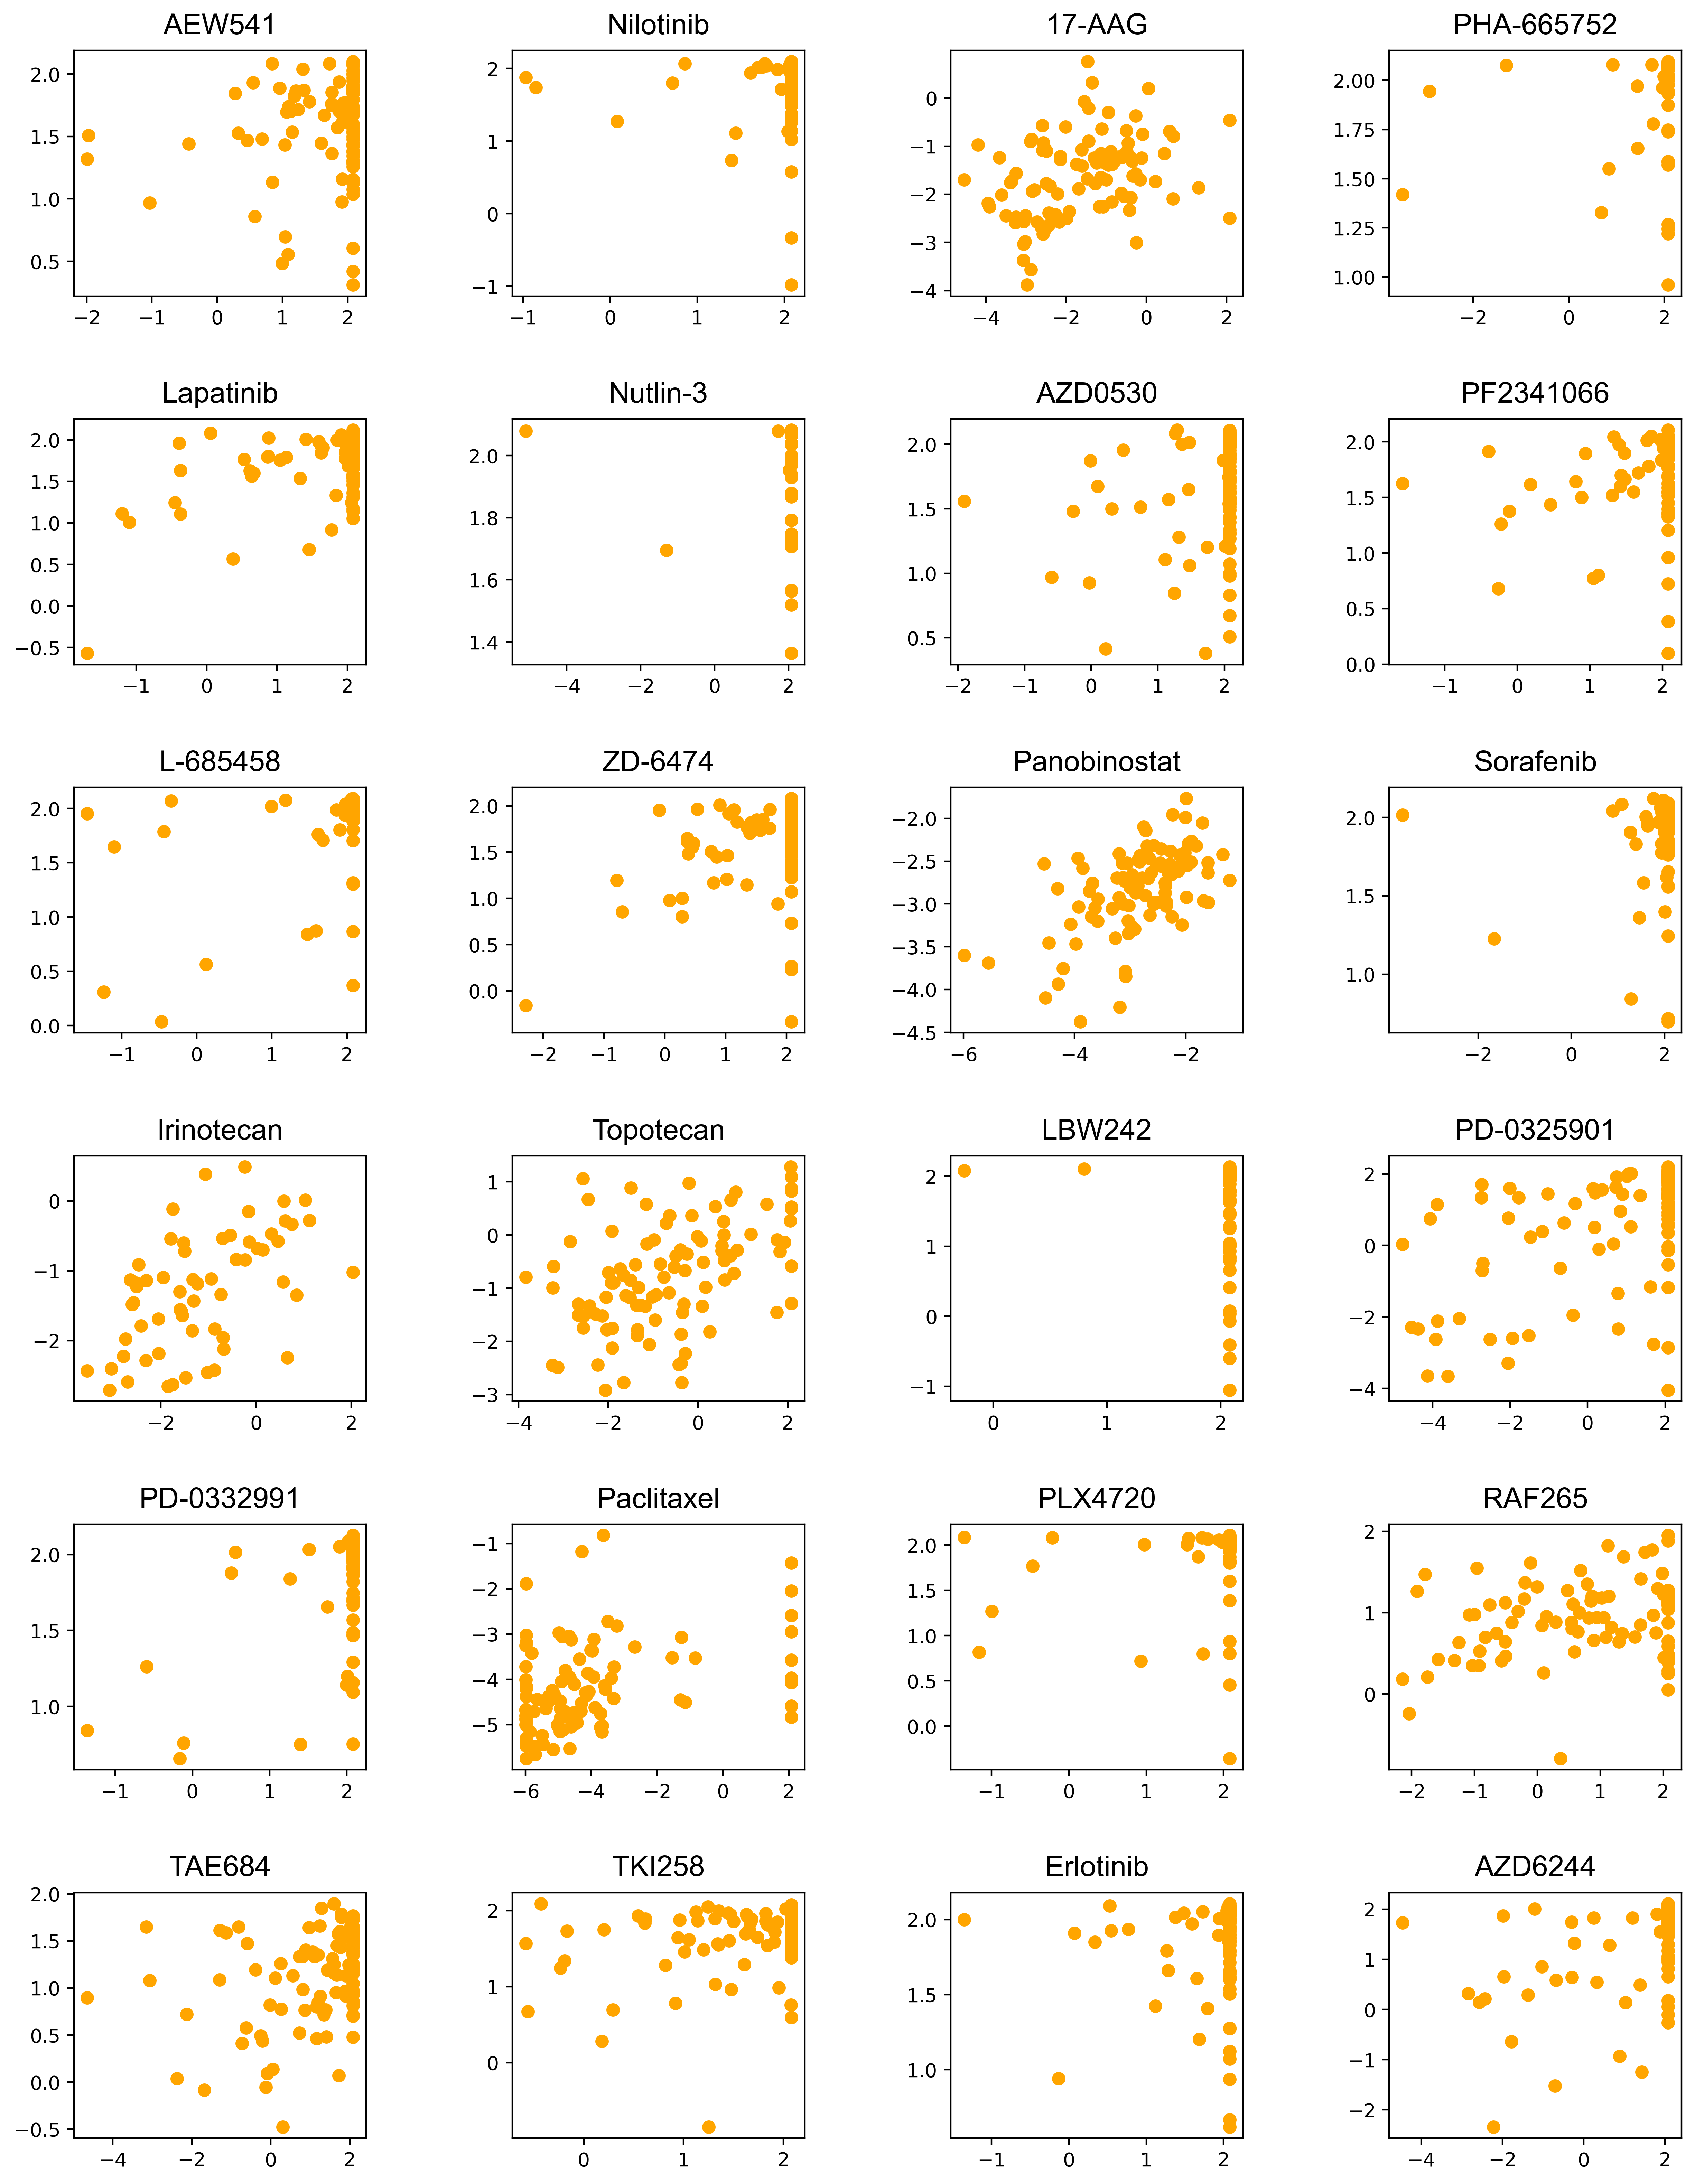

In [3]:
from datetime import datetime
now = datetime.now()
day = now.strftime("%Y%m%d")
print("Starttime: " + day)

rmselist = []
r2list = []

# drug_list = ["Topotecan"]
fig = plt.figure(figsize=(15,20),dpi=400)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
num = 1
for dname in drug_list:
    
    print('%s_//n' % dname)
    # read input file and index file for training and test set
    dataset = np.load(datasetdir + "//EC11K_%s.npz" % dname)
    ss0 = np.load(datasetdir + '//EC11K_%s_0_8_2.npz' % dname)

    # input and index file assign
    x = dataset['x']
    y = dataset['y']
    # y_linear = dataset['y_lnIC50']
    ss0_train = ss0['train']
    ss0_test = ss0['test']
    
    # z-normalization
    
    # training and test dataset assign
    train_X, train_y = x[ss0_train], y[ss0_train]
    test_X, test_y = x[ss0_test], y[ss0_test]
    
    from sklearn import preprocessing
    import pickle
    scaler = preprocessing.StandardScaler()
    train_X = scaler.fit_transform(train_X)
    pickle.dump(scaler, open(datasetdir + "//standardization_models//znorm_scaler_%s.pkl" % dname, 'wb'))
    test_X = scaler.transform(test_X)

    # data typing and the number of dataset
    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    # train_X /= 255
    # test_X /= 255
    print('train_X shape:', train_X.shape)
    print(train_X.shape[0], 'train samples')
    print(test_X.shape[0], 'test samples')
    
    # model fitting
    StartTime8 = datetime.now()
    print("StartTime :", StartTime8)
    model = xgb.XGBRegressor()
    model.fit(train_X,train_y)
    EndTime8 = datetime.now()
    print("EndTime :", EndTime8)


    predicted_classes = model.predict(test_X)
    predicted_value = predicted_classes
    
    import pickle
    import joblib
    joblib.dump(model, resultdir + '//XGBoost//EC11K_znorm_XGB_%s.pkl' % dname) 
            
    
    # saving predicted ln(IC50)s and ln(IC50)s in the test set
    a = pd.DataFrame(predicted_value)
    b = pd.DataFrame(test_y)
    c = pd.concat([a,b], axis=1)
    c.columns=["Predicted","Test"]
    c.to_csv(resultdir + '//XGBoost//predicted_table//EC11K_Ridge_%s_pred_and_val_result.csv' % dname, index=False)


    # RMSE
    rse = ((b[0]-a[0])**2).sum()
    mse = rse / len(b)
    rmse = np.sqrt(mse)
    print("%s’s final rmse value is = %f" % (dname,rmse))
    
    # R-squared value
    r2_value = r2_score(b,a)
    print("%s R-squared value is = %f" % (dname,r2_value))
    rmselist.append(rmse)
    r2list.append(r2_value)
          
    plt.subplot(6,4,num)
    plt.scatter(test_y,predicted_value,c='orange')
    plt.title(dname,fontdict ={'fontsize' : 15},fontname="Arial",y = 1.02)
    plt.tick_params(labelsize=10)
    
    num += 1
#     plt.scatter(test_y,predicted_value,c='red')
#     plt.xlabel('test_IC50_value')
#     plt.ylabel('predicted_IC50_value')
#     plt.savefig(workdir + '//%s_test_scatterplot.png' % dname)
    

figdir = "D://indivdual_models//Result//Figure"
plt.savefig(figdir +'//EC11K_single_drug_XGB_plot.png', dpi=400)

In [4]:
num

25

In [5]:
a = pd.DataFrame(drug_list)
b = pd.DataFrame(rmselist)
c =pd.DataFrame(r2list)
result = pd.concat([a,b,c],axis=1)
result.columns = ['Drug','RMSE','R2value']

In [6]:
result

,Drug,RMSE,R2value
0,AEW541,0.840320,-0.112361
1,Nilotinib,0.740697,-0.822380
2,17-AAG,1.340441,0.024034
3,PHA-665752,0.820832,0.043155
4,Lapatinib,0.705402,0.274402
5,Nutlin-3,0.802377,-0.016604
6,AZD0530,0.735625,-0.079130
7,PF2341066,0.665886,-0.009493
8,L-685458,0.662948,0.214402
9,ZD-6474,0.766626,0.081401


In [7]:
result.to_csv(resultdir +'//EC11K_XGB_24drugs_metrics.csv', index=False)